In [553]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [554]:
import os, sys


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment

In [555]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
# experiment_sub_dir = "2025Jul09-171538_configs" # good latest run
# experiment_sub_dir = "2025Sep15-090310_configs" paper run 1 finite h

# experiment_sub_dir = "2025Oct15-095412_configs"
# experiment_sub_dir = "2025Oct16-023909_configs" # linear term state
# experiment_sub_dir = "2025Oct16-100935_configs" # coca no term state
# experiment_sub_dir = "2025Oct17-101225_configs" # coca no term state higher lr
# experiment_sub_dir = "2025Oct17-154612_configs" # coca no term state higher lr more epochs
# experiment_sub_dir = "2025Oct18-002003_configs" # coca no term state higher lr new params
# experiment_sub_dir = "2025Oct18-135551_configs" # coca no term state higher lr new params
# experiment_sub_dir = "2025Oct19-030258_configs" # coca no term state higher lr even more new params
# experiment_sub_dir = "2025Oct19-182701_configs" # coca no term state higher lr even more new params
# experiment_sub_dir = "2025Oct27-022212_configs" # good params!

experiment_sub_dir = (
    "2025Oct28-115156_configs"  # coca no term state higher lr even more new params
)


exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(exp_path)
# df.columns

In [556]:
# df[df['epoch_type'] == 'training']

In [557]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.target_soft_tau',
       'sub_exp_cfg_experiment', 'sub_experiment_path', 'seed',
       'experiment_na

In [558]:
df[df['epoch_type'] == 'validation']

# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg(
    {
        "episode_rewards_mean": "mean",  # Averaging the performance metric
        "sub_experiment_path": "first",  # Keep a reference to an experiment path
    }
)

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results["episode_rewards_mean"].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.lr                            1e-05
sub_exp_cfg_agent_params.args_.target_soft_tau       0.0005
sub_exp_cfg_experiment                            fixed_res
Name: 1, dtype: object
Best mean reward: -8.442268997124547


In [559]:
averaged_results

,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.target_soft_tau,sub_exp_cfg_experiment,episode_rewards_mean,sub_experiment_path
0,1e-05,0.0001,fixed_res,-9.508862,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,1e-05,0.0005,fixed_res,-8.442269,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,3e-05,0.0001,fixed_res,-8.518361,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,3e-05,0.0005,fixed_res,-8.682563,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [560]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

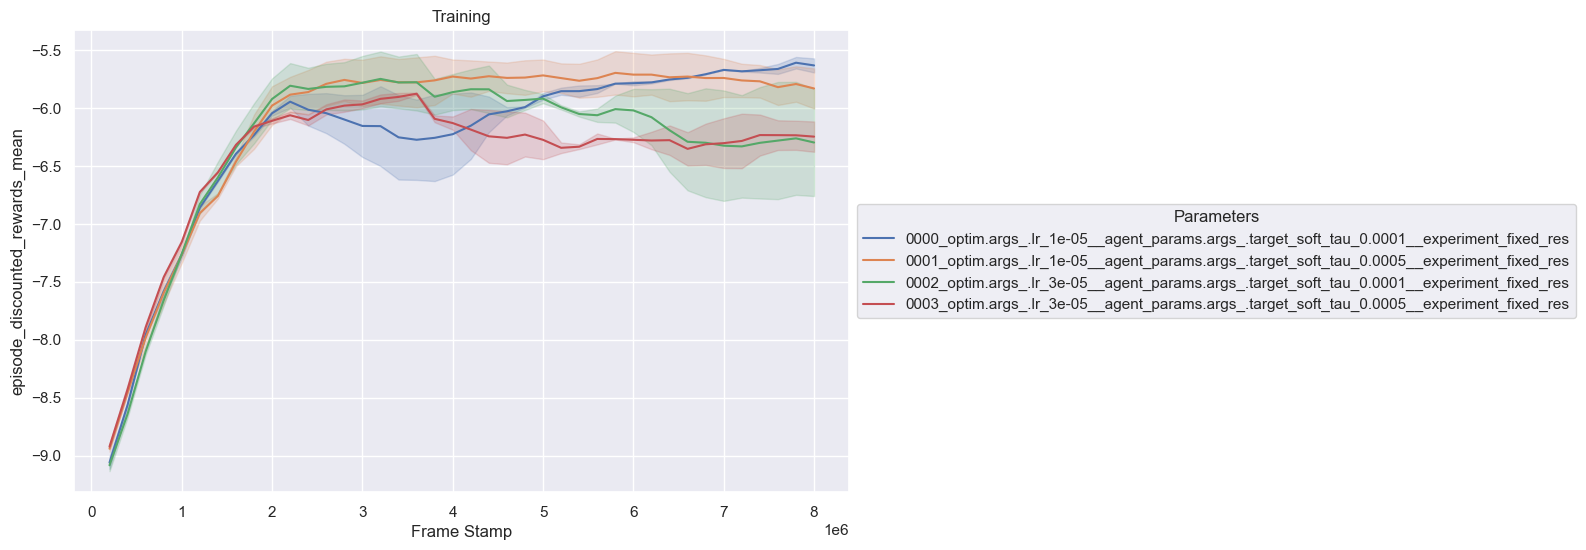

In [561]:
selected_metric = "episode_discounted_rewards_mean"
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df["epoch_type"] == "training"]

# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(
    data=validation_df,
    x="frame_stamp",
    y=selected_metric,
    hue=hue_col,
    #  units='seed', # Comment this to see mean + cf
    #  estimator=None, # Comment this to see mean + cf
)

plt.ylabel(selected_metric)
plt.xlabel("Frame Stamp")
plt.title("Training")

# Place the legend outside the plot
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Parameters")
plt.show()

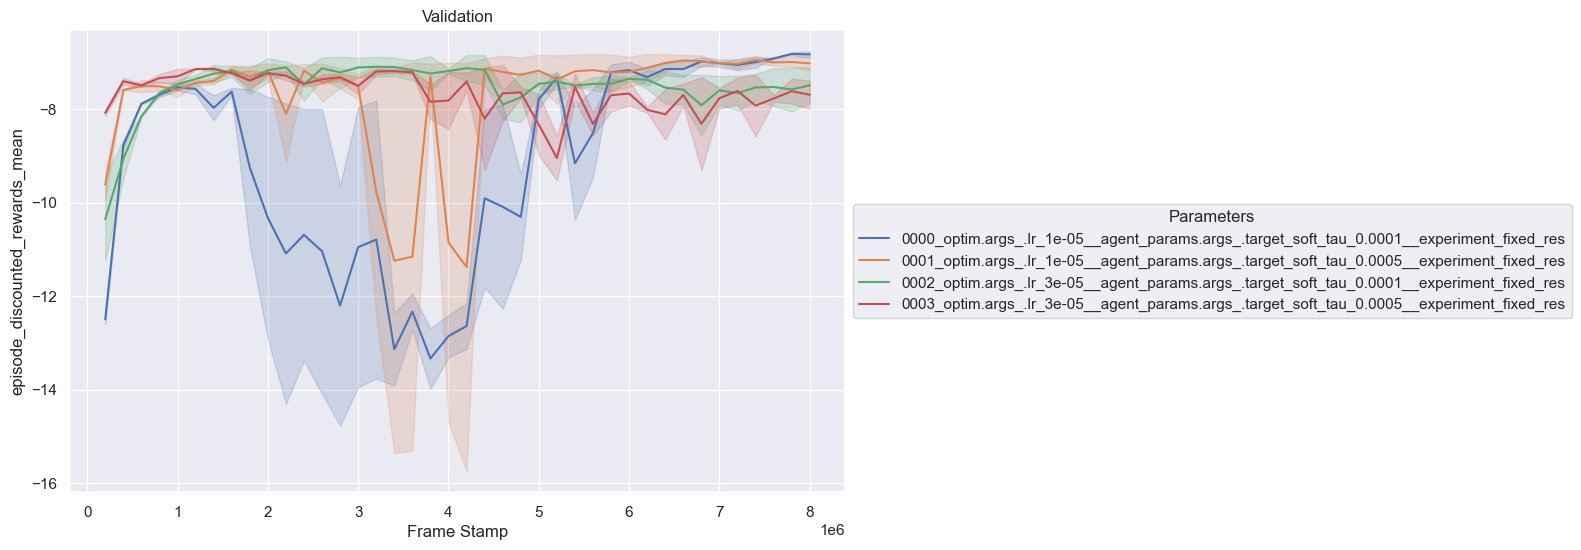

In [562]:
selected_metric = "episode_discounted_rewards_mean"
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df["epoch_type"] == "validation"]
# validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(
    data=validation_df,
    x="frame_stamp",
    y=selected_metric,
    hue=hue_col,
    #  units='seed', # Comment this to see mean + cf
    #  estimator=None, # Comment this to see mean + cf
)

plt.ylabel(selected_metric)
plt.xlabel("Frame Stamp")
plt.title("Validation")

# Place the legend outside the plot
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Parameters")
plt.show()

In [563]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.target_soft_tau',
       'sub_exp_cfg_experiment', 'sub_experiment_path', 'seed',
       'experiment_na

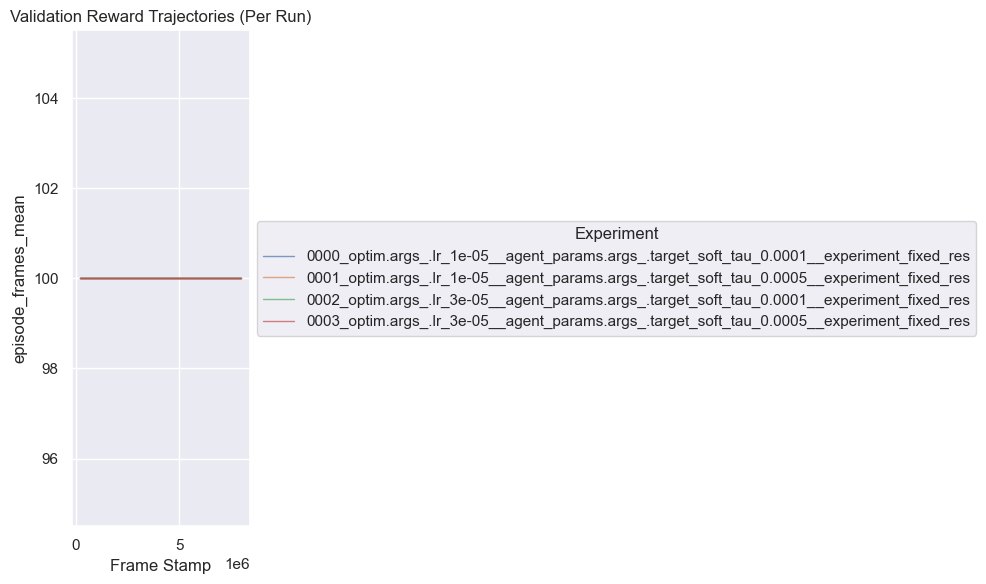

In [564]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = "episode_frames_mean"
hue_col = (
    "experiment_name"  # or another distinguishing column like "sub_experiment_path"
)

validation_df = df[df["epoch_type"] == "validation"]

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x="frame_stamp",
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units="sub_experiment_path",  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7,  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel("Frame Stamp")
plt.title("Validation Reward Trajectories (Per Run)")

# Move legend outside the plot
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Experiment")
plt.tight_layout()
plt.show()

In [565]:
### Select data

experiment_columns = [
    "epoch_type",
    "frame_stamp",
    "episode_rewards_mean",
    "episode_frames_mean",
    "episode_discounted_rewards_mean",
    "policy_trained_times",
    "target_trained_times",
    "epoch_time",
    "seed",
    "experiment_name",
    "sub_experiment_path",
]
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df["epoch_type"] == "validation"]
sub_df = sub_df[sub_df["frame_stamp"] == sub_df["frame_stamp"].max()]

sub_df

,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.target_soft_tau,sub_exp_cfg_experiment
79,validation,8000000,-8.265361,100.0,-6.903580,NaN,NaN,0 days 00:00:10.308355,0,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0001,fixed_res
159,validation,8000000,-7.999318,100.0,-6.764878,NaN,NaN,0 days 00:00:09.645577,1,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0001,fixed_res
239,validation,8000000,-8.105728,100.0,-6.879205,NaN,NaN,0 days 00:00:08.207341,0,0001_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0005,fixed_res
319,validation,8000000,-8.591009,100.0,-7.171684,NaN,NaN,0 days 00:00:09.931322,1,0001_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0005,fixed_res
399,validation,8000000,-8.546730,100.0,-7.113320,NaN,NaN,0 days 00:00:10.226805,0,0002_optim.args_.lr_3e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,3e-05,0.0001,fixed_res
479,validation,8000000,-9.972037,100.0,-7.875975,NaN,NaN,0 days 00:00:08.271002,1,0002_optim.args_.lr_3e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,3e-05,0.0001,fixed_res
559,validation,8000000,-8.945104,100.0,-7.391949,NaN,NaN,0 days 00:00:11.370256,0,0003_optim.args_.lr_3e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,3e-05,0.0005,fixed_res
639,validation,8000000,-9.652870,100.0,-8.000772,NaN,NaN,0 days 00:00:08.414362,1,0003_optim.args_.lr_3e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,3e-05,0.0005,fixed_res


In [566]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.target_soft_tau,sub_exp_cfg_experiment,episode_discounted_rewards_mean
0,1e-05,0.0001,fixed_res,-6.834229
1,1e-05,0.0005,fixed_res,-7.025445
2,3e-05,0.0001,fixed_res,-7.494648
3,3e-05,0.0005,fixed_res,-7.696360


In [567]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.target_soft_tau',
       'sub_exp_cfg_experiment'],
      dtype='object')

## Best final model

In [568]:
print(
    sub_df[sub_df["episode_rewards_mean"] == sub_df["episode_rewards_mean"].max()][
        "sub_experiment_path"
    ].values[0]
)

d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct28-115156_configs\0000_optim.args_.lr_1e-05__agent_params.args_.target_soft_tau_0.0001__experiment_fixed_res\1


In [569]:
sub_df[sub_df["episode_rewards_mean"] == sub_df["episode_rewards_mean"].max()]

,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.target_soft_tau,sub_exp_cfg_experiment
159,validation,8000000,-7.999318,100.0,-6.764878,NaN,NaN,0 days 00:00:09.645577,1,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0001,fixed_res


## Best checkpoint

In [570]:
import os, json, ast
from typing import Any, Dict, Optional, Union, Tuple
import pandas as pd

# -----------------------------
# Config parse/load helpers
# -----------------------------
_CFG_CANDIDATES = [
    "cfg.yaml", "config.yaml", "config.yml", "cfg.yml",
    "config.json", "cfg.json"
]

def _parse_cfg_str_or_dict(cfg_str_or_dict: Union[str, dict]) -> dict:
    if isinstance(cfg_str_or_dict, dict):
        return cfg_str_or_dict
    text = str(cfg_str_or_dict)
    # try YAML
    try:
        import yaml
        cfg = yaml.safe_load(text)
        if isinstance(cfg, dict): return cfg
    except Exception:
        pass
    # try JSON
    try:
        cfg = json.loads(text)
        if isinstance(cfg, dict): return cfg
    except Exception:
        pass
    # try Python literal
    try:
        cfg = ast.literal_eval(text)
        if isinstance(cfg, dict): return cfg
    except Exception:
        pass
    raise ValueError("Could not parse config string into a dict.")

def _load_cfg_from_path(run_path: str) -> Optional[dict]:
    if not isinstance(run_path, str) or not run_path:
        return None
    # search run_path and a few parents
    search_dirs = []
    p = os.path.abspath(run_path)
    for _ in range(4):  # current + 3 parents
        search_dirs.append(p)
        new_p = os.path.dirname(p)
        if new_p == p: break
        p = new_p

    for d in search_dirs:
        for fname in _CFG_CANDIDATES:
            fpath = os.path.join(d, fname)
            if os.path.isfile(fpath):
                try:
                    if fpath.endswith((".yaml", ".yml")):
                        import yaml
                        with open(fpath, "r", encoding="utf-8") as f:
                            cfg = yaml.safe_load(f)
                    else:
                        with open(fpath, "r", encoding="utf-8") as f:
                            cfg = json.load(f)
                    if isinstance(cfg, dict):
                        return cfg
                except Exception as e:
                    print(f"[WARN] Failed reading {fpath}: {e}")
    return None

def _steps_per_epoch_from_cfg(cfg: dict, *, include_validation: bool = False) -> int:
    agent_params = cfg.get("agent_params", {}) or {}
    args_ = agent_params.get("args_", {}) or {}

    train_step_cnt = int(args_.get("train_step_cnt", 0) or 0)
    if train_step_cnt <= 0:
        raise ValueError("train_step_cnt missing/zero; cannot compute steps_per_epoch.")

    if include_validation and bool(args_.get("validation_enabled", False)):
        val_cnt = int(args_.get("validation_step_cnt", 0) or 0)
        return train_step_cnt + val_cnt

    return train_step_cnt

# -----------------------------------------
# Annotate df with steps_per_epoch & index
# -----------------------------------------
def annotate_with_checkpoint_idx(
    df: pd.DataFrame,
    *,
    cfg_col_fallback: str = "sub_exp_cfg_experiment",
) -> pd.DataFrame:
    """
    Adds two columns: 'steps_per_epoch' and 'checkpoint_idx'.
    Reads cfg from disk near 'sub_experiment_path'; falls back to parsing cfg_col_fallback if present.
    """
    required = {"sub_experiment_path", "frame_stamp"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    out = df.copy()
    spe_cache: Dict[str, Optional[int]] = {}
    cfg_col_exists = cfg_col_fallback in out.columns

    def _get_spe(path: str, cfg_blob: Any) -> Optional[int]:
        if path in spe_cache:
            return spe_cache[path]
        cfg = _load_cfg_from_path(path)
        if cfg is None and cfg_col_exists and pd.notna(cfg_blob):
            try:
                cfg = _parse_cfg_str_or_dict(cfg_blob)
            except Exception:
                cfg = None
        if cfg is None:
            spe_cache[path] = None
            return None
        try:
            spe = _steps_per_epoch_from_cfg(cfg)
            spe_cache[path] = int(spe)
            return int(spe)
        except Exception:
            spe_cache[path] = None
            return None

    steps_per_epoch = []
    checkpoint_idx = []
    for _, row in out.iterrows():
        path = row["sub_experiment_path"]
        cfg_blob = row[cfg_col_fallback] if cfg_col_exists else None
        spe = _get_spe(path, cfg_blob)
        steps_per_epoch.append(spe)
        if spe is None:
            checkpoint_idx.append(None)
        else:
            try:
                frame = int(row["frame_stamp"])
                checkpoint_idx.append(int(round(frame / int(spe))))
            except Exception:
                checkpoint_idx.append(None)

    out["steps_per_epoch"] = steps_per_epoch
    out["checkpoint_idx"] = checkpoint_idx
    return out

# -----------------------------------------
# Best checkpoint (keeps your original prints)
# -----------------------------------------
def find_best_checkpoint_from_logs(
    df: pd.DataFrame,
    *,
    tie_breaker: Optional[str] = "episode_rewards_median",
) -> Dict[str, Any]:
    required = {"epoch_type", "episode_rewards_mean", "frame_stamp", "sub_experiment_path"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"DataFrame is missing required columns: {sorted(missing)}")

    val = df[df["epoch_type"] == "validation"].copy()
    if val.empty:
        raise ValueError("No validation rows found in df.")

    sort_cols = ["episode_rewards_mean"]
    ascending = [False]
    if tie_breaker is not None and tie_breaker in val.columns:
        sort_cols.append(tie_breaker)
        ascending.append(False)

    best_per_run = (
        val.sort_values(sort_cols, ascending=ascending)
           .groupby("sub_experiment_path", as_index=False, sort=False)
           .head(1)
    )
    best_row = best_per_run.sort_values(sort_cols, ascending=ascending).iloc[0]

    # We expect 'checkpoint_idx' & 'steps_per_epoch' to already exist (from annotate_with_checkpoint_idx)
    checkpoint_idx = best_row.get("checkpoint_idx", None)
    steps_per_epoch = best_row.get("steps_per_epoch", None)

    hyperparam_columns = [c for c in df.columns if c.startswith("sub_exp_cfg")]
    hyperparams = {k: best_row[k] for k in hyperparam_columns if k in best_row.index}

    return {
        "sub_experiment_path": best_row["sub_experiment_path"],
        "checkpoint_idx": None if pd.isna(checkpoint_idx) else int(checkpoint_idx),
        "frame_stamp": int(best_row["frame_stamp"]),
        "episode_rewards_mean": float(best_row["episode_rewards_mean"]),
        "steps_per_epoch": None if pd.isna(steps_per_epoch) else int(steps_per_epoch),
        "hyperparams": hyperparams,
    }

# ======================
# === CALL + PRINTS ====
# ======================

# 1) annotate df with steps_per_epoch + checkpoint_idx
df_aug = annotate_with_checkpoint_idx(df)

# 2) your original "best run" print (preserved)
best = find_best_checkpoint_from_logs(df_aug)

print("=== Best validation checkpoint across all sub-experiments ===")
print(f"Sub-experiment path : {best['sub_experiment_path']}")
print(f"Checkpoint index     : {best['checkpoint_idx']}  (frame_stamp={best['frame_stamp']}, steps/epoch={best['steps_per_epoch']})")
print(f"Mean reward (val)    : {best['episode_rewards_mean']:.4f}")

if best.get("hyperparams"):
    print("\nHyperparameters for best run:")
    for k, v in best["hyperparams"].items():
        print(f"  {k}: {v}")

# 3) your original "top-5 validation checkpoints" print (preserved)
val = df_aug[df_aug["epoch_type"] == "validation"].copy()
secondary = "episode_rewards_median" if "episode_rewards_median" in val.columns else "episode_rewards_mean"
top5 = (
    val.sort_values(["episode_rewards_mean", secondary], ascending=[False, False])
       .loc[:, ["sub_experiment_path", "frame_stamp", "steps_per_epoch", "checkpoint_idx", "episode_rewards_mean"]]
       .head(5)
)

print("\n=== Top-5 validation checkpoints (for quick inspection) ===")
print(top5.to_string(index=False))



=== Best validation checkpoint across all sub-experiments ===
Sub-experiment path : d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct28-115156_configs\0001_optim.args_.lr_1e-05__agent_params.args_.target_soft_tau_0.0005__experiment_fixed_res\0
Checkpoint index     : 27  (frame_stamp=5400000, steps/epoch=200000)
Mean reward (val)    : -7.9962

Hyperparameters for best run:
  sub_exp_cfg_optim.args_.lr: 1e-05
  sub_exp_cfg_agent_params.args_.target_soft_tau: 0.0005
  sub_exp_cfg_experiment: fixed_res

=== Top-5 validation checkpoints (for quick inspection) ===
                                                                                                                                                                         sub_experiment_path  frame_stamp  steps_per_epoch  checkpoint_idx  episode_rewards_mean
d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct28-115156_configs\0001_optim.args_.lr_1e-05__agent_params.args_.target_

In [571]:
wanted_cols = [
    "sub_experiment_path",
    "epoch_type",
    "frame_stamp",
    "episode_rewards_mean",
    "episode_rewards_median",      # may not exist
    "episode_rewards_std",         # nice to see spread
    "greedy_epsilon",              # sanity check exploration
    "policy_trained_times",        # progress markers
    "target_trained_times",
    "sub_exp_cfg_experiment",      # raw cfg (string or dict)
]

# Keep only those that actually exist
cols = [c for c in wanted_cols if c in df.columns]
df[cols].head()

,sub_experiment_path,epoch_type,frame_stamp,episode_rewards_mean,episode_rewards_median,episode_rewards_std,greedy_epsilon,policy_trained_times,target_trained_times,sub_exp_cfg_experiment
0,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,training,200000,-11.363055,-11.186576,2.000582,0.90975,47499.0,0.0,fixed_res
1,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,training,400000,-10.817092,-10.644067,1.829778,0.81475,50000.0,0.0,fixed_res
2,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,training,600000,-9.985639,-9.895639,1.547925,0.71975,50000.0,0.0,fixed_res
3,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,training,800000,-9.519608,-9.447236,1.380046,0.62475,50000.0,0.0,fixed_res
4,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,training,1000000,-9.049368,-8.956075,1.296069,0.52975,50000.0,0.0,fixed_res


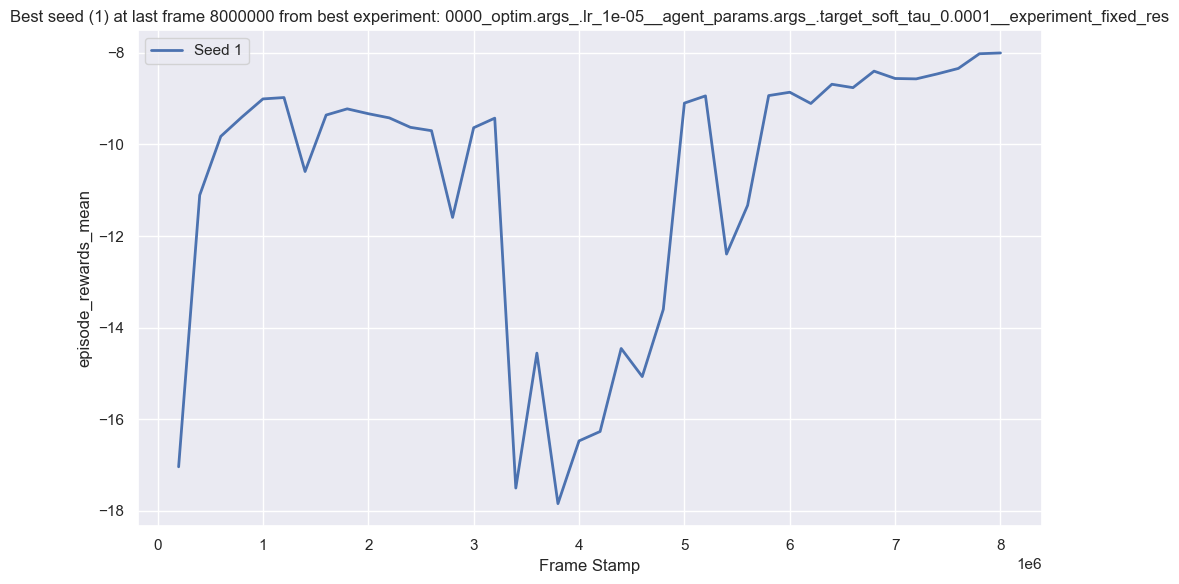

In [572]:
selected_metric = "episode_rewards_mean"
hue_col = "experiment_name"

val_df = df[df["epoch_type"] == "validation"].copy()

# 1) Last global frame
last_frame = val_df["frame_stamp"].max()
last_df = val_df[val_df["frame_stamp"] == last_frame]

# 2) Best experiment by mean at LAST frame (averaged across seeds)
best_experiment = last_df.groupby(hue_col)[selected_metric].mean().idxmax()

# 3) Within that experiment, the best seed at LAST frame
best_seed = (
    last_df[last_df[hue_col] == best_experiment]
    .groupby("seed")[selected_metric]
    .mean()
    .idxmax()
)

# 4) Plot the whole curve for that experiment+seed (not just the final point)
best_seed_df = val_df[
    (val_df[hue_col] == best_experiment) & (val_df["seed"] == best_seed)
]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x="frame_stamp",
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}",
)
plt.title(
    f"Best seed ({best_seed}) at last frame {last_frame} from best experiment: {best_experiment}"
)
plt.ylabel(selected_metric)
plt.xlabel("Frame Stamp")
plt.legend()
plt.tight_layout()
plt.show()

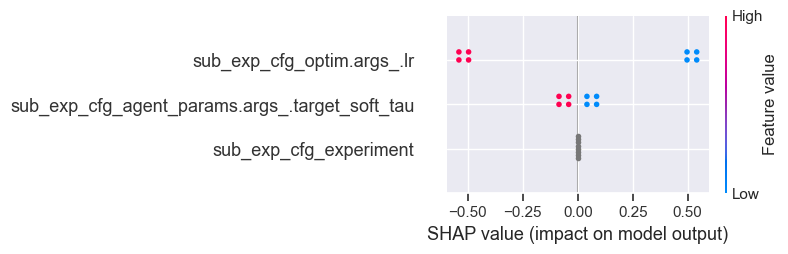

In [573]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors="coerce")
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(
    objective="reg:squarederror", n_estimators=100, random_state=42
)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [574]:
# Minimal cell to PRINT compact SHAP data you can paste back here

import numpy as np
import pandas as pd

# Use the same X and shap_values from your previous cell
X_num = X.apply(pd.to_numeric, errors="coerce").fillna(X.median(numeric_only=True))

# Global importance = mean(|SHAP|) per feature
sv = shap_values
vals = (
    sv.values if hasattr(sv, "values") else sv
)  # support both SHAP objects & raw arrays
mean_abs = np.mean(np.abs(vals), axis=0)

# Direction: correlation between SHAP value and raw feature (helps read summary plot colors)
corrs = []
for i, col in enumerate(X_num.columns):
    xcol = X_num.iloc[:, i].to_numpy()
    sval = vals[:, i]
    # robust correlation: handle constant columns or NaNs
    if np.allclose(xcol, xcol[0]) or np.all(np.isnan(xcol)):
        corrs.append(np.nan)
    else:
        c = np.corrcoef(xcol, sval)[0, 1]
        corrs.append(c)

global_df = pd.DataFrame(
    {
        "feature": X_num.columns,
        "mean_abs_shap": mean_abs,
        "corr_sign": np.sign(
            corrs
        ),  # +1 ≈ higher feature -> higher prediction; -1 opposite
        "corr_value": corrs,
    }
).sort_values("mean_abs_shap", ascending=False)

# Keep per-row SHAP small: only top-10 features
topk = 10 if len(global_df) > 10 else len(global_df)
top_feats = global_df["feature"].head(topk).tolist()
top_idx = [X_num.columns.get_loc(f) for f in top_feats]
perrow_df = pd.DataFrame(vals[:, top_idx], columns=top_feats, index=sub_df.index)

# Also handy context
meta_df = pd.DataFrame(
    {"prediction": model.predict(X_num), target_metric: sub_df[target_metric].values},
    index=sub_df.index,
)

# ---- PRINT CSV blocks you can paste here ----
print("# --- shap_global.csv ---")
print(global_df.to_csv(index=False))

print("# --- shap_values_top10.csv ---")
print(perrow_df.to_csv())

print("# --- shap_meta.csv ---")
print(meta_df.to_csv())

# --- shap_global.csv ---
feature,mean_abs_shap,corr_sign,corr_value
sub_exp_cfg_optim.args_.lr,0.51903373,-1.0,-0.9991001969133011
sub_exp_cfg_agent_params.args_.target_soft_tau,0.063563325,-1.0,-0.944845989011814
sub_exp_cfg_experiment,0.0,,

# --- shap_values_top10.csv ---
,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.target_soft_tau,sub_exp_cfg_experiment
79,0.54106694,0.08559648,0.0
159,0.54106694,0.08559648,0.0
239,0.49700055,-0.08559648,0.0
319,0.49700055,-0.08559648,0.0
399,-0.54106694,0.041530166,0.0
479,-0.54106694,0.041530166,0.0
559,-0.49700055,-0.041530166,0.0
639,-0.49700055,-0.041530166,0.0

# --- shap_meta.csv ---
,prediction,episode_rewards_mean
79,-8.133107,-8.265360638397672
159,-8.133107,-7.999317697103687
239,-8.348366,-8.105728200650406
319,-8.348366,-8.59100915594546
399,-9.259309,-8.546729861251624
479,-9.259309,-9.97203665652245
559,-9.298302,-8.945103999156157
639,-9.298302,-9.65287004871617



In [575]:
hyperparam_columns

['sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_agent_params.args_.target_soft_tau',
 'sub_exp_cfg_experiment']

In [576]:
import plotly.express as px

# --- config ---
target_col = "episode_rewards_mean"  # your target metric
color_col = "experiment_name"  # optional color grouping
readable_names = {
    # optional friendly names; falls back to raw column name if missing
    # "hp_raw_name": "Pretty Name",
}

# --- build plots ---
varying_hps = [hp for hp in hyperparam_columns if sub_df[hp].nunique(dropna=False) > 1]

if not varying_hps:
    print("No hyperparameters with more than one unique value — nothing to plot.")
else:
    for hp in varying_hps:
        # Rename only the current x column (leave others as-is for hover)
        x_name = readable_names.get(hp, hp)
        plot_df = sub_df.rename(columns={hp: x_name})

        fig = px.scatter(
            plot_df,
            x=x_name,
            y=target_col,
            color=color_col if color_col in plot_df.columns else None,
            hover_data=hyperparam_columns,  # handy to inspect full config per point
            title=f"{target_col} vs {x_name} (varying: {sub_df[hp].nunique(dropna=False)})",
            height=500,
        )
        fig.update_traces(mode="markers", marker=dict(size=8, opacity=0.8))
        fig.update_layout(showlegend=False)
        fig.show()